In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [2]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Conv3D, Conv3DTranspose, Add, Input, Cropping3D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom  # For resizing images

# Paths to dataset
image_path = r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images"
label_path = r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels"

In [3]:
# Load file names
image_files = sorted(os.listdir(image_path))
label_files = sorted(os.listdir(label_path))

# Split data (train/test)
train_img, test_img, train_lbl, test_lbl = train_test_split(image_files, label_files, test_size=0.2, random_state=42)

# Define target shape for resizing
target_shape = (54, 54, 38)


class NiftiDataGenerator(Sequence):
    def __init__(self, image_dir, label_dir, image_filenames, label_filenames, batch_size=2, target_shape=(54, 54, 38)):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_filenames = image_filenames
        self.label_filenames = label_filenames
        self.batch_size = batch_size
        self.target_shape = target_shape

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.label_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, labels = [], []
        for img_file, lbl_file in zip(batch_images, batch_labels):
            img_data = nib.load(os.path.join(self.image_dir, img_file)).get_fdata()
            lbl_data = nib.load(os.path.join(self.label_dir, lbl_file)).get_fdata()

            # Compute zoom factors for resizing
            img_zoom = [t / s for s, t in zip(img_data.shape, self.target_shape)]
            lbl_zoom = [t / s for s, t in zip(lbl_data.shape, self.target_shape)]

            img_resized = zoom(img_data, img_zoom, order=1)  # Bilinear interpolation for images
            lbl_resized = zoom(lbl_data, lbl_zoom, order=0)  # Nearest-neighbor for labels

            images.append(img_resized[..., np.newaxis])  # Add channel dim
            labels.append((lbl_resized > 0).astype(np.uint8)[..., np.newaxis])  # Convert to binary mask

        return np.array(images), np.array(labels)

# Initialize generators with resized data
batch_size = 2
train_generator = NiftiDataGenerator(image_path, label_path, train_img, train_lbl, batch_size, target_shape)
test_generator = NiftiDataGenerator(image_path, label_path, test_img, test_lbl, batch_size, target_shape)


In [4]:
# Define V-Net architecture
def vnet_block(x, filters):
    res = Conv3D(filters, (3, 3, 3), padding="same", activation="relu")(x)
    res = Conv3D(filters, (3, 3, 3), padding="same", activation="relu")(res)
    return Add()([x, res])


In [5]:
def build_3d_vnet(input_shape=(54, 54, 38, 1)):
    inputs = Input(input_shape)

    # Encoder
    e1 = Conv3D(16, (3, 3, 3), activation="relu", padding="same")(inputs)
    e1 = vnet_block(e1, 16)
    e2 = Conv3D(32, (3, 3, 3), strides=2, padding="same", activation="relu")(e1)
    e2 = vnet_block(e2, 32)
    e3 = Conv3D(64, (3, 3, 3), strides=2, padding="same", activation="relu")(e2)
    e3 = vnet_block(e3, 64)

    # Bottleneck
    b = vnet_block(e3, 64)  # Ensure bottleneck matches e3 (64 filters)

    # Decoder
    d3 = Conv3DTranspose(64, (3, 3, 3), strides=2, padding="same", activation="relu")(b)
    d3 = Cropping3D(cropping=((0, 0), (0, 0), (0, 0)))(e3)  # Crop encoder output to match decoder
    d3 = Add()([d3, e3])
    d3 = vnet_block(d3, 64)
    d2 = Conv3DTranspose(32, (3, 3, 3), strides=2, padding="same", activation="relu")(d3)
    d2 = Cropping3D(cropping=((0, 0), (0, 0), (0, 0)))(e2)  # Crop encoder output to match decoder
    d2 = Add()([d2, e2])
    d2 = vnet_block(d2, 32)
    d1 = Conv3DTranspose(16, (3, 3, 3), strides=2, padding="same", activation="relu")(d2)
    d1 = Cropping3D(cropping=((0, 0), (0, 0), (0, 0)))(e1)  # Crop encoder output to match decoder
    d1 = Add()([d1, e1])
    d1 = vnet_block(d1, 16)
    outputs = Conv3D(1, (1, 1, 1), activation="sigmoid")(d1)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# Build model with fixed input shape
print("Building V-Net...")
model = build_3d_vnet(input_shape=target_shape + (1,))

# Train model
print("Starting training...")
history = model.fit(train_generator, epochs=20, validation_data=test_generator)

Building V-Net...
Starting training...
Epoch 1/20


c:\Users\joshc\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 433ms/step - accuracy: 0.9664 - loss: 2.2778 - val_accuracy: 0.9771 - val_loss: 0.6621
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 318ms/step - accuracy: 0.9817 - loss: 0.4864 - val_accuracy: 0.9783 - val_loss: 0.4259
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 318ms/step - accuracy: 0.9829 - loss: 0.3288 - val_accuracy: 0.9784 - val_loss: 0.3512
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 315ms/step - accuracy: 0.9840 - loss: 0.2649 - val_accuracy: 0.9805 - val_loss: 0.2754
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 313ms/step - accuracy: 0.9853 - loss: 0.2087 - val_accuracy: 0.9840 - val_loss: 0.2348
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 314ms/step - accuracy: 0.9874 - loss: 0.1712 - val_accuracy: 0.9842 - val_loss: 0.1957
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 312ms/step - accuracy: 0.9874 - loss: 0.1497 - val_accuracy: 0.9841 - val_loss: 0.1720
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 314ms/step - accuracy: 0.9872 - loss: 0.1355 - val_accuracy: 0.984

In [7]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 54, 54,    │          0 │ -                 │
│ (InputLayer)        │ 38, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 54, 54,    │        448 │ input_layer[0][0] │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 54, 54,    │      6,928 │ conv3d[0][0]      │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 54, 54,    │      6,928 │ conv3d_1[0][0]    │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 54, 54,    │          0 │ conv3d[0][0],     │
│                     │ 38, 16)           │            │ conv3d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping3d_2        │ (None, 54, 54,    │          0 │ add[0][0]         │
│ (Cropping3D)        │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 54, 54,    │          0 │ cropping3d_2[0][… │
│                     │ 38, 16)           │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_15 (Conv3D)  │ (None, 54, 54,    │      6,928 │ add_8[0][0]       │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_16 (Conv3D)  │ (None, 54, 54,    │      6,928 │ conv3d_15[0][0]   │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 54, 54,    │          0 │ add_8[0][0],      │
│                     │ 38, 16)           │            │ conv3d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_17 (Conv3D)  │ (None, 54, 54,    │         17 │ add_9[0][0]       │
│                     │ 38, 1)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,533 (330.21 KB)

 Trainable params: 28,177 (110.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 56,356 (220.14 KB)

In [8]:
model.save(r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\3d_vnet_model.h5")


In [9]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

def load_and_preprocess(nifti_file_path):
    """Load a NIfTI file and return its data as a numpy array"""
    nifti_img = nib.load(nifti_file_path)
    nifti_data = nifti_img.get_fdata()
    return nifti_data, nifti_img.affine

def visualize_3d_data(image_data, label_data=None, threshold=0.5):
    """Visualize 3D data with sliders for navigating through slices"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Get the dimensions
    x_max, y_max, z_max = image_data.shape
    
    # Create normalized image data for display
    norm_image = (image_data - image_data.min()) / (image_data.max() - image_data.min())
    
    # Initial slice indices (middle of the volume)
    x_slice, y_slice, z_slice = x_max // 2, y_max // 2, z_max // 2
    
    # Display initial slices
    ax1_img = axes[0].imshow(norm_image[x_slice, :, :].T, cmap='gray')
    axes[0].set_title(f'Sagittal Slice ({x_slice}/{x_max})')
    axes[0].set_ylabel('Z axis')
    axes[0].set_xlabel('Y axis')
    
    ax2_img = axes[1].imshow(norm_image[:, y_slice, :].T, cmap='gray')
    axes[1].set_title(f'Coronal Slice ({y_slice}/{y_max})')
    axes[1].set_ylabel('Z axis')
    axes[1].set_xlabel('X axis')
    
    ax3_img = axes[2].imshow(norm_image[:, :, z_slice], cmap='gray')
    axes[2].set_title(f'Axial Slice ({z_slice}/{z_max})')
    axes[2].set_ylabel('Y axis')
    axes[2].set_xlabel('X axis')
    
    # If we have label data, overlay it with transparency
    if label_data is not None:
        ax1_label = axes[0].imshow(label_data[x_slice, :, :].T, cmap='hot', alpha=0.3)
        ax2_label = axes[1].imshow(label_data[:, y_slice, :].T, cmap='hot', alpha=0.3)
        ax3_label = axes[2].imshow(label_data[:, :, z_slice], cmap='hot', alpha=0.3)
    
    # Add sliders for navigation
    ax_x = plt.axes([0.15, 0.01, 0.65, 0.03])
    ax_y = plt.axes([0.15, 0.05, 0.65, 0.03])
    ax_z = plt.axes([0.15, 0.09, 0.65, 0.03])
    
    slider_x = Slider(ax_x, 'Sagittal Slice', 0, x_max-1, valinit=x_slice, valstep=1)
    slider_y = Slider(ax_y, 'Coronal Slice', 0, y_max-1, valinit=y_slice, valstep=1)
    slider_z = Slider(ax_z, 'Axial Slice', 0, z_max-1, valinit=z_slice, valstep=1)
    
    def update(val):
        x_slice = int(slider_x.val)
        y_slice = int(slider_y.val)
        z_slice = int(slider_z.val)
        
        ax1_img.set_data(norm_image[x_slice, :, :].T)
        axes[0].set_title(f'Sagittal Slice ({x_slice}/{x_max})')
        
        ax2_img.set_data(norm_image[:, y_slice, :].T)
        axes[1].set_title(f'Coronal Slice ({y_slice}/{y_max})')
        
        ax3_img.set_data(norm_image[:, :, z_slice])
        axes[2].set_title(f'Axial Slice ({z_slice}/{z_max})')
        
        if label_data is not None:
            ax1_label.set_data(label_data[x_slice, :, :].T)
            ax2_label.set_data(label_data[:, y_slice, :].T)
            ax3_label.set_data(label_data[:, :, z_slice])
        
        fig.canvas.draw_idle()
    
    slider_x.on_changed(update)
    slider_y.on_changed(update)
    slider_z.on_changed(update)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

Found 123 image files and 123 label files
Sample 1/123
Loading image: C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images\liver_0.nii
Loading label: C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels\liver_0.nii
Image shape: (180, 180, 125)
Label shape: (180, 180, 125)
Displaying slice viewer...


C:\Users\joshc\AppData\Local\Temp\ipykernel_12176\2107698552.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


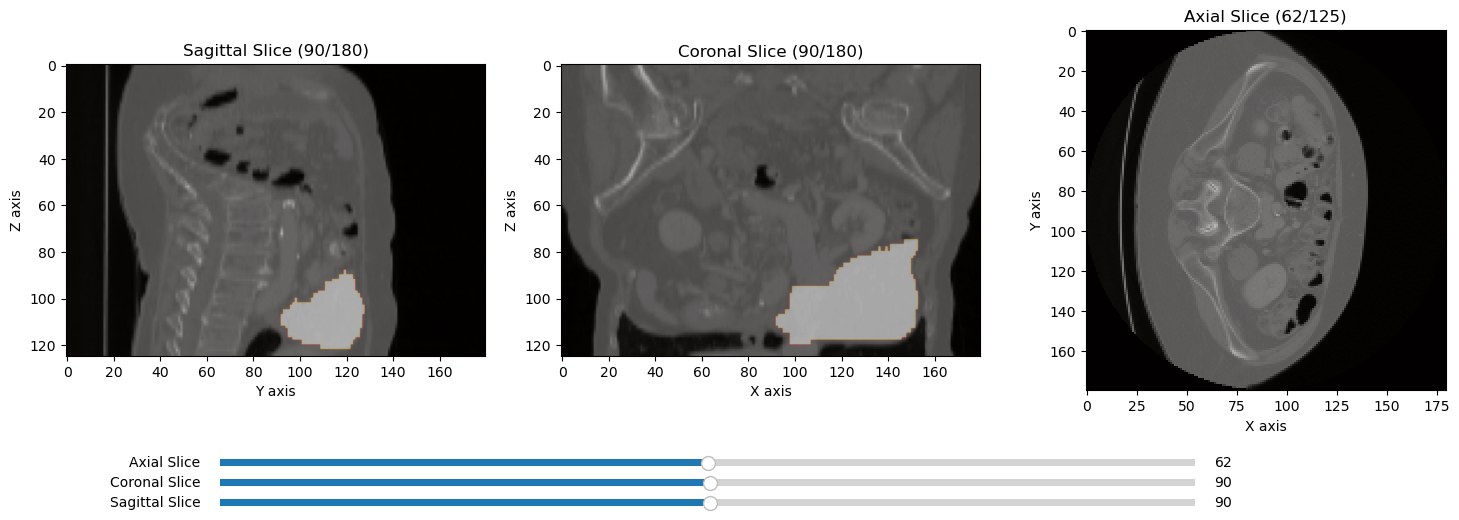

Generating 3D surface visualization...


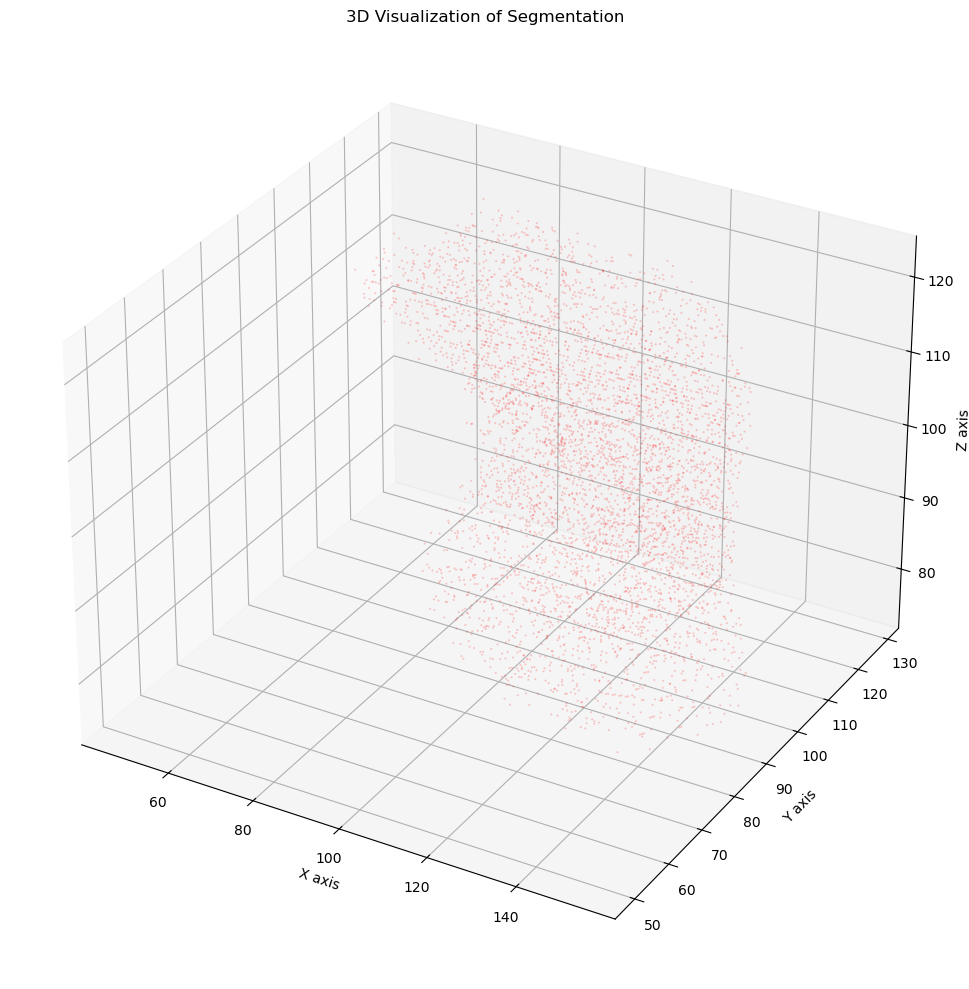

Sample 2/123
Loading image: C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images\liver_1.nii
Loading label: C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels\liver_1.nii
Image shape: (173, 173, 205)
Label shape: (173, 173, 205)
Displaying slice viewer...


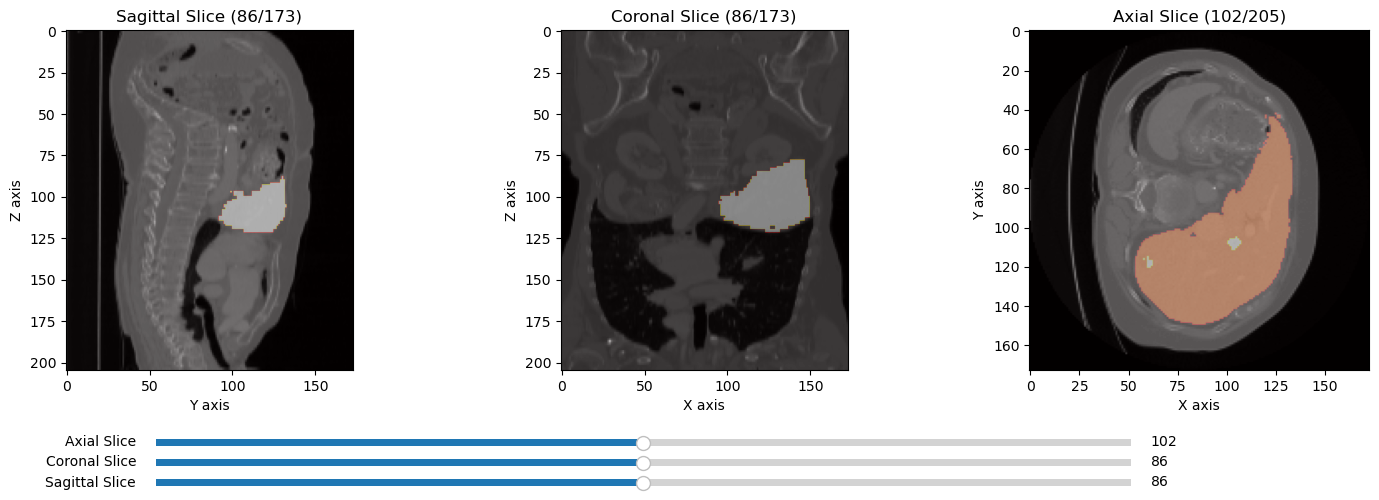

In [10]:
def visualize_3d_surface(label_data, threshold=0.5):
    """Visualize a 3D surface from label data"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create binary mask and get coordinates of segmented regions
    mask = label_data > threshold
    x, y, z = np.where(mask)
    
    # Downsample points for better performance (if necessary)
    downsample_ratio = len(x) // 5000 + 1
    x = x[::downsample_ratio]
    y = y[::downsample_ratio]
    z = z[::downsample_ratio]
    
    # Plot the 3D surface
    ax.scatter(x, y, z, c='red', marker='.', alpha=0.2, s=1)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Visualization of Segmentation')
    
    plt.tight_layout()
    plt.show()

# Example usage function
def visualize_liver_dataset(image_file, label_file):
    """Load and visualize a liver image and its segmentation"""
    print(f"Loading image: {image_file}")
    image_data, _ = load_and_preprocess(image_file)
    
    print(f"Loading label: {label_file}")
    label_data, _ = load_and_preprocess(label_file)
    
    print("Image shape:", image_data.shape)
    print("Label shape:", label_data.shape)
    
    # Visualize slices with label overlay
    print("Displaying slice viewer...")
    visualize_3d_data(image_data, label_data)
    
    # Optionally visualize 3D surface (may be slow for large volumes)
    response = input("Would you like to visualize the 3D surface? (y/n): ")
    if response.lower() == 'y':
        print("Generating 3D surface visualization...")
        visualize_3d_surface(label_data)

# Example visualization function for all dataset samples
def explore_dataset(image_path, label_path):
    """Interactive function to explore all samples in the dataset"""
    image_files = sorted([os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.nii') or f.endswith('.nii.gz')])
    label_files = sorted([os.path.join(label_path, f) for f in os.listdir(label_path) if f.endswith('.nii') or f.endswith('.nii.gz')])
    
    print(f"Found {len(image_files)} image files and {len(label_files)} label files")
    
    if len(image_files) != len(label_files):
        print("Warning: Number of image files doesn't match number of label files")
    
    sample_pairs = list(zip(image_files, label_files))
    
    for i, (img_file, lbl_file) in enumerate(sample_pairs):
        print(f"Sample {i+1}/{len(sample_pairs)}")
        visualize_liver_dataset(img_file, lbl_file)
        
        if i < len(sample_pairs) - 1:
            response = input("Continue to next sample? (y/n): ")
            if response.lower() != 'y':
                break
#To use this code, uncomment and modify these lines with your paths:
image_path = r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images"
label_path = r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels"
explore_dataset(image_path, label_path)

# Or to visualize a specific pair:
# image_file = os.path.join(image_path, "first_image.nii.gz")
# label_file = os.path.join(label_path, "first_label.nii.gz")
# visualize_liver_dataset(image_file, label_file)

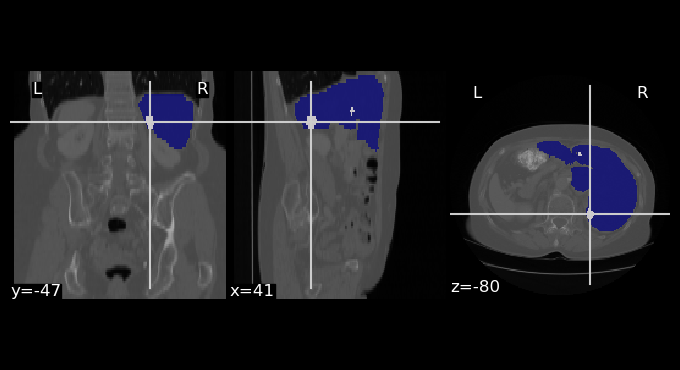

In [ ]:
# Replace with your actual paths
image_path = r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images"
label_path = r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels"

# Get the first image and label file
image_files = sorted(os.listdir(image_path))
label_files = sorted(os.listdir(label_path))

image_file = os.path.join(image_path, image_files[0])
label_file = os.path.join(label_path, label_files[0])

# Use the nilearn visualization
from nilearn import plotting
plotting.plot_roi(label_file, bg_img=image_file, display_mode='ortho')
plt.show()

In [8]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.ndimage import zoom

# Path to your saved model
model_path = r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\3d_vnet_model.h5"

# Load the saved model
model = load_model(model_path)

# Print model summary to verify it loaded correctly
print("Model loaded successfully!")
print(model.summary())

# Define paths to your dataset for visualization/inference
image_path = r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images"
label_path = r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels"

# Define target shape (same as used during training)
target_shape = (54, 54, 38)

# Function to preprocess an image for the model
def preprocess_image(nifti_file, target_shape=(54, 54, 38)):
    """Load and preprocess a NIfTI file for model inference"""
    # Load NIfTI file
    nifti_img = nib.load(nifti_file)
    nifti_data = nifti_img.get_fdata()
    
    # Calculate zoom factors
    zoom_factors = [t / s for s, t in zip(nifti_data.shape, target_shape)]
    
    # Resize image to target shape
    img_resized = zoom(nifti_data, zoom_factors, order=1)
    
    # Add batch and channel dimensions
    img_input = np.expand_dims(np.expand_dims(img_resized, axis=0), axis=-1)
    
    return img_input, nifti_img.affine, nifti_data.shape

# Function to make a prediction and convert back to original size
def predict_segmentation(model, nifti_file, target_shape=(54, 54, 38)):
    """Predict segmentation and return it in original image space"""
    # Preprocess the image
    img_input, affine, orig_shape = preprocess_image(nifti_file, target_shape)
    
    # Make prediction
    prediction = model.predict(img_input)[0, ..., 0]
    
    # Resize prediction back to original dimensions
    inverse_zoom = [s / t for s, t in zip(orig_shape, target_shape)]
    pred_orig_size = zoom(prediction, inverse_zoom, order=0)
    
    # Threshold prediction (binary segmentation)
    pred_binary = (pred_orig_size > 0.5).astype(np.uint8)
    
    return pred_binary, affine

# Function to save a prediction as a NIfTI file
def save_prediction(prediction, affine, output_file):
    """Save a prediction array as a NIfTI file"""
    pred_nifti = nib.Nifti1Image(prediction, affine)
    nib.save(pred_nifti, output_file)
    print(f"Prediction saved to {output_file}")

# Example: Make a prediction on a test image
def run_inference_example():
    # Get a list of image files
    image_files = sorted(os.listdir(image_path))
    
    if len(image_files) == 0:
        print("No image files found!")
        return
    
    # Select the first image file (or any other file you want)
    test_file = os.path.join(image_path, image_files[0])
    print(f"Running inference on: {test_file}")
    
    # Make prediction
    prediction, affine = predict_segmentation(model, test_file, target_shape)
    
    # Save prediction
    output_file = r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\prediction.nii.gz"
    save_prediction(prediction, affine, output_file)
    
    print("Inference completed successfully!")

# Uncomment to run inference on a test image
run_inference_example()

Model loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 54, 54,    │          0 │ -                 │
│ (InputLayer)        │ 38, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 54, 54,    │        448 │ input_layer[0][0] │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 54, 54,    │      6,928 │ conv3d[0][0]      │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 54, 54,    │      6,928 │ conv3d_1[0][0]    │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 54, 54,    │          0 │ conv3d[0][0],     │
│                     │ 38, 16)           │            │ conv3d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping3d_2        │ (None, 54, 54,    │          0 │ add[0][0]         │
│ (Cropping3D)        │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 54, 54,    │          0 │ cropping3d_2[0][… │
│                     │ 38, 16)           │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_15 (Conv3D)  │ (None, 54, 54,    │      6,928 │ add_8[0][0]       │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_16 (Conv3D)  │ (None, 54, 54,    │      6,928 │ conv3d_15[0][0]   │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 54, 54,    │          0 │ add_8[0][0],      │
│                     │ 38, 16)           │            │ conv3d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_17 (Conv3D)  │ (None, 54, 54,    │         17 │ add_9[0][0]       │
│                     │ 38, 1)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,179 (110.08 KB)

 Trainable params: 28,177 (110.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Running inference on: C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images\liver_0.nii
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Prediction saved to C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\prediction.nii.gz
Inference completed successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction saved to prediction.nii.gz


C:\Users\joshc\AppData\Local\Temp\ipykernel_23352\3511284551.py:218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


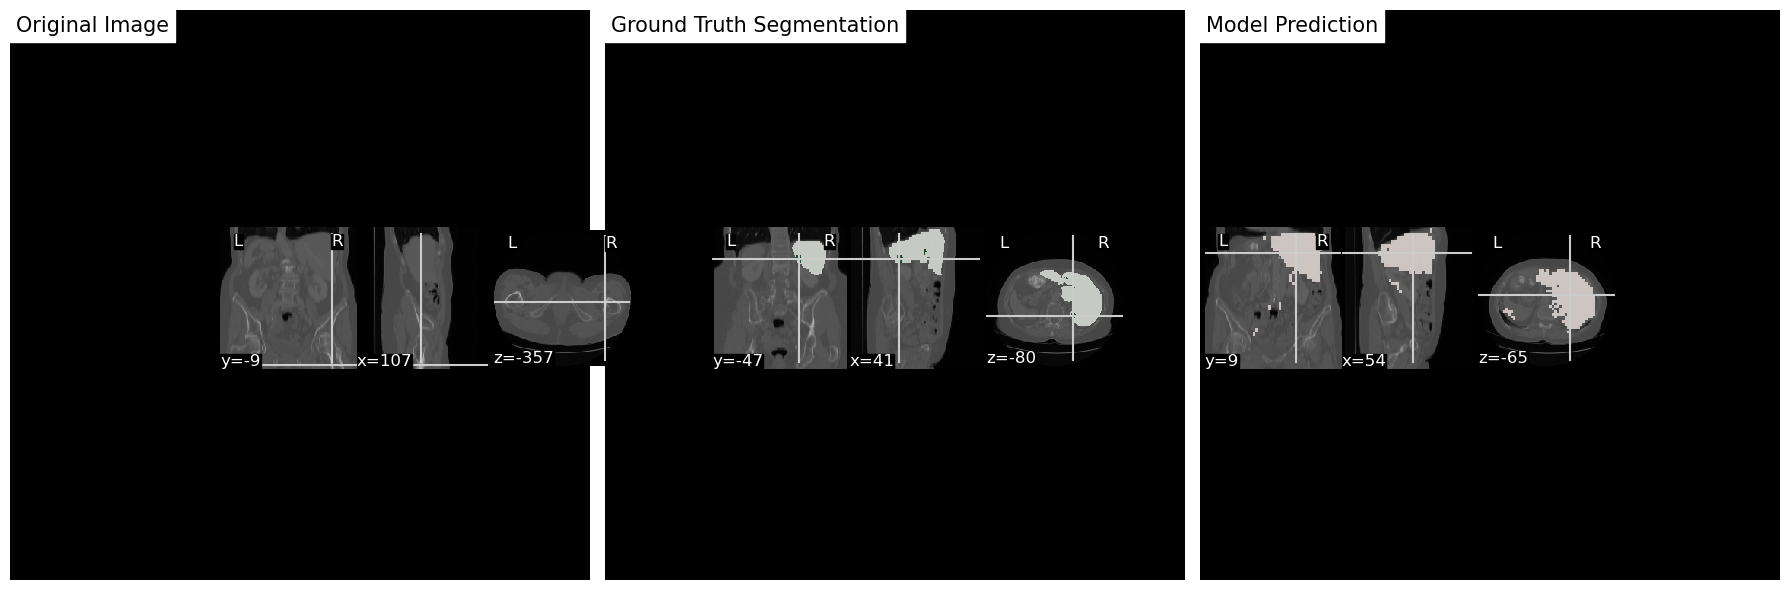

In [16]:
# Import necessary libraries if not already imported
import os
import numpy as np
# Assuming your other imports are already in place

# Define your image and label paths
image_path = r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images"
label_path = r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels"

# Get the list of files in each directory
image_files = sorted([f for f in os.listdir(image_path) if f.endswith('.nii')])
label_files = sorted([f for f in os.listdir(label_path) if f.endswith('.nii')])

# Choose a test image 
test_index = 0  # Adjust this based on which image you want to test
test_image_file = image_files[test_index]
test_label_file = label_files[test_index]

# Generate prediction for the test image
test_image_path = os.path.join(image_path, test_image_file)
output_pred_path = 'prediction.nii.gz'

# Save prediction as NIfTI
save_prediction_as_nifti(model, test_image_path, output_pred_path)

# Compare with ground truth
test_label_path = os.path.join(label_path, test_label_file)
visualize_model_predictions(test_image_path, test_label_path, output_pred_path)

In [3]:
import os
import nibabel as nib
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

# Install nilearn if you don't have it
# !pip install nilearn

def visualize_with_nilearn(image_file, label_file=None, display_mode='ortho', colormap='gray'):
    """
    Visualize NIfTI files using nilearn's plotting functions
    
    Parameters:
    -----------
    image_file : str
        Path to the NIfTI image file (.nii or .nii.gz)
    label_file : str, optional
        Path to the segmentation label file (.nii or .nii.gz)
    display_mode : str, optional
        Display mode: 'ortho', 'x', 'y', 'z', 'yx', 'xz', 'yz'
    colormap : str, optional
        Colormap for the background image
    """
    # Load image
    img = nib.load(image_file)
    
    # Create the visualization
    if label_file is not None:
        # Load label
        label_img = nib.load(label_file)
        
        # Create an overlay visualization
        display = plotting.plot_roi(
            label_img, 
            bg_img=img,
            display_mode=display_mode,
            colorbar=True,
            cmap='hot',
            alpha=0.7,
            bg_vmin=np.percentile(img.get_fdata(), 5),
            bg_vmax=np.percentile(img.get_fdata(), 95),
            title=f"Image with Segmentation Overlay\nDisplayMode: {display_mode}"
        )
    else:
        # Display just the image
        display = plotting.plot_anat(
            img,
            display_mode=display_mode,
            colorbar=True,
            cmap=colormap,
            vmin=np.percentile(img.get_fdata(), 5),
            vmax=np.percentile(img.get_fdata(), 95),
            title=f"3D Image\nDisplayMode: {display_mode}"
        )
    
    plt.show()
    return display

def interactive_viewer(image_file, label_file=None):
    """
    Interactive viewer for NIfTI files with sliders
    
    Parameters:
    -----------
    image_file : str
        Path to the NIfTI image file (.nii or .nii.gz)
    label_file : str, optional
        Path to the segmentation label file (.nii or .nii.gz)
    """
    # Load data
    img = nib.load(image_file)
    img_data = img.get_fdata()
    
    if label_file is not None:
        label_img = nib.load(label_file)
        label_data = label_img.get_fdata()
    else:
        label_data = None
    
    # Create plotting function for interact
    def view_slice(axis, slice_idx, opacity=0.5):
        plt.figure(figsize=(10, 8))
        
        if axis == 'x':
            plt.imshow(img_data[slice_idx, :, :].T, cmap='gray', origin='lower')
            if label_data is not None:
                plt.imshow(label_data[slice_idx, :, :].T, cmap='hot', alpha=opacity, origin='lower')
            plt.title(f'Sagittal Slice {slice_idx}')
            plt.xlabel('Y axis')
            plt.ylabel('Z axis')
        elif axis == 'y':
            plt.imshow(img_data[:, slice_idx, :].T, cmap='gray', origin='lower')
            if label_data is not None:
                plt.imshow(label_data[:, slice_idx, :].T, cmap='hot', alpha=opacity, origin='lower')
            plt.title(f'Coronal Slice {slice_idx}')
            plt.xlabel('X axis')
            plt.ylabel('Z axis')
        else:  # axis == 'z'
            plt.imshow(img_data[:, :, slice_idx], cmap='gray', origin='lower')
            if label_data is not None:
                plt.imshow(label_data[:, :, slice_idx], cmap='hot', alpha=opacity, origin='lower')
            plt.title(f'Axial Slice {slice_idx}')
            plt.xlabel('X axis')
            plt.ylabel('Y axis')
        
        plt.colorbar(label='Intensity')
        if label_data is not None:
            plt.colorbar(label='Label Value')
        plt.tight_layout()
    
    # Create interactive visualization
    x_max, y_max, z_max = img_data.shape
    
    # Use interact for interactive visualization
    interact(
        view_slice,
        axis=widgets.Dropdown(options=['x', 'y', 'z'], value='z', description='Axis:'),
        slice_idx=widgets.IntSlider(min=0, max=max(x_max, y_max, z_max)-1, step=1, value=z_max//2, description='Slice:'),
        opacity=widgets.FloatSlider(min=0, max=1, step=0.1, value=0.5, description='Overlay:')
    )

def explore_liver_dataset(image_path, label_path):
    """
    Interactive function to explore all samples in the liver tumor dataset
    
    Parameters:
    -----------
    image_path : str
        Path to directory containing image files
    label_path : str
        Path to directory containing label files
    """
    # Get file lists
    image_files = sorted([os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.nii') or f.endswith('.nii.gz')])
    label_files = sorted([os.path.join(label_path, f) for f in os.listdir(label_path) if f.endswith('.nii') or f.endswith('.nii.gz')])
    
    print(f"Found {len(image_files)} image files and {len(label_files)} label files")
    
    # Create a file selector widget
    file_selector = widgets.Dropdown(
        options=[(os.path.basename(img), (img, lbl)) for img, lbl in zip(image_files, label_files)],
        description='Select file:',
        style={'description_width': 'initial'},
        layout={'width': '50%'}
    )
    
    # Visualization mode selector
    display_mode = widgets.RadioButtons(
        options=['ortho', 'x', 'y', 'z', 'yx', 'xz', 'yz'],
        value='ortho',
        description='Display mode:',
        disabled=False
    )
    
    # View type selector
    view_type = widgets.RadioButtons(
        options=['nilearn', 'interactive'],
        value='nilearn',
        description='View type:',
        disabled=False
    )
    
    # Function to handle visualization
    def on_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            img_file, lbl_file = file_selector.value
            if view_type.value == 'nilearn':
                visualize_with_nilearn(img_file, lbl_file, display_mode=display_mode.value)
            else:
                interactive_viewer(img_file, lbl_file)
    
    # Register callback
    file_selector.observe(on_change, names='value')
    display_mode.observe(on_change, names='value')
    view_type.observe(on_change, names='value')
    
    # Layout widgets
    display(widgets.VBox([file_selector, display_mode, view_type]))
    
    # Initial visualization
    img_file, lbl_file = file_selector.value
    if view_type.value == 'nilearn':
        visualize_with_nilearn(img_file, lbl_file, display_mode=display_mode.value)
    else:
        interactive_viewer(img_file, lbl_file)

# Visualization function for your model's predictions
def visualize_model_predictions(image_file, true_label_file, predicted_label_file):
    """
    Visualize model predictions compared to ground truth
    
    Parameters:
    -----------
    image_file : str
        Path to the NIfTI image file
    true_label_file : str
        Path to the ground truth label file
    predicted_label_file : str
        Path to the predicted label file
    """
    # Load data
    img = nib.load(image_file)
    true_label = nib.load(true_label_file)
    pred_label = nib.load(predicted_label_file)
    
    # Create 3x1 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Create displays
    display1 = plotting.plot_anat(img, figure=fig, axes=axes[0], title="Original Image")
    display2 = plotting.plot_roi(true_label, bg_img=img, figure=fig, axes=axes[1], 
                              title="Ground Truth Segmentation", cmap='Greens')
    display3 = plotting.plot_roi(pred_label, bg_img=img, figure=fig, axes=axes[2], 
                              title="Model Prediction", cmap='Reds')
    
    plt.tight_layout()
    plt.show()

# Example: To convert your model predictions to NIfTI for visualization
def save_prediction_as_nifti(model, image_file, output_file, target_shape=(54, 54, 38)):
    """
    Generate and save model predictions as NIfTI files
    
    Parameters:
    -----------
    model : tensorflow.keras.Model
        Trained segmentation model
    image_file : str
        Path to the input NIfTI image
    output_file : str
        Path to save the prediction NIfTI file
    target_shape : tuple, optional
        Target shape for model input
    """
    from scipy.ndimage import zoom
    
    # Load image
    img = nib.load(image_file)
    img_data = img.get_fdata()
    affine = img.affine
    
    # Resize to model input shape
    orig_shape = img_data.shape
    zoom_factors = [t / s for s, t in zip(orig_shape, target_shape)]
    img_resized = zoom(img_data, zoom_factors, order=1)
    
    # Add batch and channel dimensions
    model_input = np.expand_dims(np.expand_dims(img_resized, axis=0), axis=-1)
    
    # Generate prediction
    prediction = model.predict(model_input)[0, ..., 0]
    
    # Resize back to original dimensions
    inverse_zoom = [s / t for s, t in zip(orig_shape, target_shape)]
    pred_orig_size = zoom(prediction, inverse_zoom, order=0)
    
    # Threshold prediction if needed (binary segmentation)
    pred_binary = (pred_orig_size > 0.5).astype(np.uint8)
    
    # Save as NIfTI
    pred_nifti = nib.Nifti1Image(pred_binary, affine)
    nib.save(pred_nifti, output_file)
    
    print(f"Prediction saved to {output_file}")

# To use these functions with your dataset, uncomment and modify:
image_path = r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images"
label_path = r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\08-3D-Liver-Tumor-Segmentation\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels"
explore_liver_dataset(image_path, label_path)

Found 123 image files and 123 label files


TypeError: nilearn.plotting.img_plotting._plot_img_with_bg() got multiple values for keyword argument 'bg_vmin'

interactive(children=(Dropdown(description='Axis:', index=2, options=('x', 'y', 'z'), value='z'), IntSlider(va…

Visualizing results...


C:\Users\joshc\AppData\Local\Temp\ipykernel_23352\2529192826.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


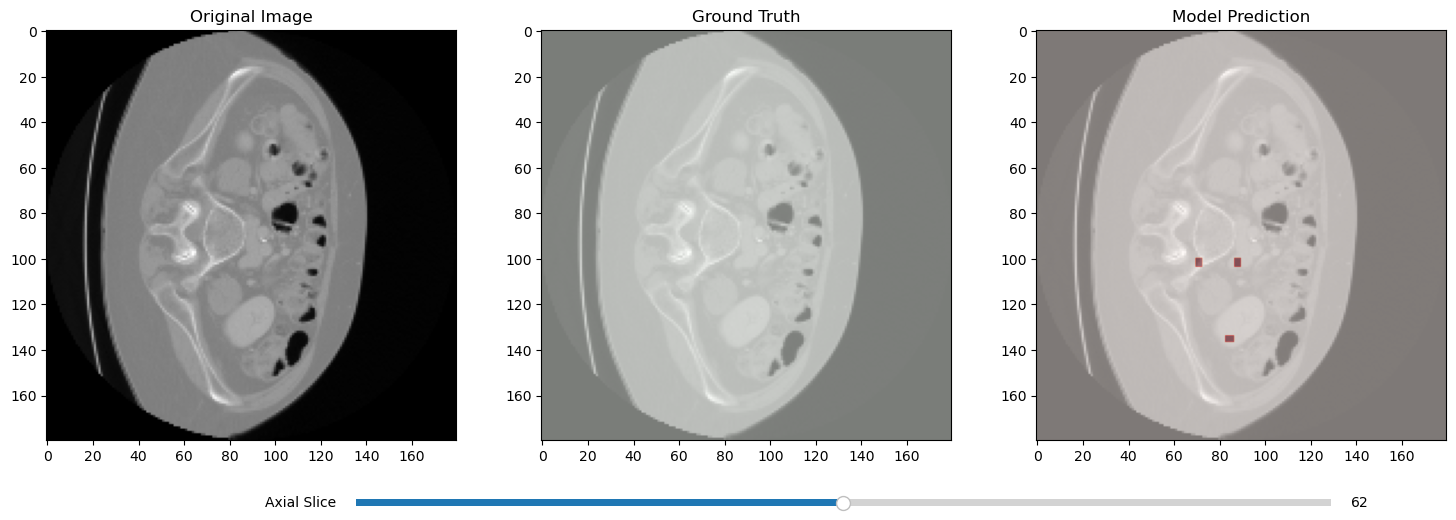


Segmentation Performance Metrics:
Dice: 0.8342
Iou: 0.7155
Sensitivity: 0.8582
Specificity: 0.9942


In [4]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from nilearn import plotting

# Function to visualize original image, ground truth, and prediction
def visualize_results(image_file, label_file, prediction_file):
    """
    Visualize the original image, ground truth, and model prediction
    
    Parameters:
    -----------
    image_file : str
        Path to the original NIfTI image
    label_file : str
        Path to the ground truth label
    prediction_file : str
        Path to the predicted segmentation
    """
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Use nilearn for visualization
    display1 = plotting.plot_anat(
        image_file, 
        title="Original Image", 
        figure=fig, 
        axes=axes[0], 
        display_mode='ortho'
    )
    
    display2 = plotting.plot_roi(
        label_file, 
        bg_img=image_file, 
        title="Ground Truth", 
        figure=fig, 
        axes=axes[1], 
        display_mode='ortho', 
        cmap='Greens'
    )
    
    display3 = plotting.plot_roi(
        prediction_file, 
        bg_img=image_file, 
        title="Model Prediction", 
        figure=fig, 
        axes=axes[2], 
        display_mode='ortho', 
        cmap='Reds'
    )
    
    plt.tight_layout()
    plt.show()

# Function to visualize slices with interactive sliders
def visualize_slices(image_file, label_file=None, prediction_file=None):
    """
    Visualize slices with interactive sliders for comparison
    
    Parameters:
    -----------
    image_file : str
        Path to the original NIfTI image
    label_file : str, optional
        Path to the ground truth label
    prediction_file : str, optional
        Path to the predicted segmentation
    """
    # Load data
    img = nib.load(image_file)
    img_data = img.get_fdata()
    
    if label_file:
        label_img = nib.load(label_file)
        label_data = label_img.get_fdata()
    else:
        label_data = None
        
    if prediction_file:
        pred_img = nib.load(prediction_file)
        pred_data = pred_img.get_fdata()
    else:
        pred_data = None
    
    # Get image dimensions
    x_max, y_max, z_max = img_data.shape
    
    # Create figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Initial slice (middle of volume)
    z_slice = z_max // 2
    
    # Normalize image for display
    norm_img = (img_data - img_data.min()) / (img_data.max() - img_data.min())
    
    # Display initial slices
    ax1_img = axes[0].imshow(norm_img[:, :, z_slice], cmap='gray')
    axes[0].set_title('Original Image')
    
    if label_data is not None:
        ax2_img = axes[1].imshow(norm_img[:, :, z_slice], cmap='gray')
        ax2_label = axes[1].imshow(label_data[:, :, z_slice], cmap='Greens', alpha=0.5)
        axes[1].set_title('Ground Truth')
    
    if pred_data is not None:
        ax3_img = axes[2].imshow(norm_img[:, :, z_slice], cmap='gray')
        ax3_pred = axes[2].imshow(pred_data[:, :, z_slice], cmap='Reds', alpha=0.5)
        axes[2].set_title('Model Prediction')
    
    # Add slider for navigation
    ax_z = plt.axes([0.25, 0.01, 0.65, 0.03])
    slider_z = Slider(ax_z, 'Axial Slice', 0, z_max-1, valinit=z_slice, valstep=1)
    
    # Update function for slider
    def update(val):
        z_slice = int(slider_z.val)
        
        # Update original image
        ax1_img.set_data(norm_img[:, :, z_slice])
        
        # Update ground truth overlay
        if label_data is not None:
            ax2_img.set_data(norm_img[:, :, z_slice])
            ax2_label.set_data(label_data[:, :, z_slice])
        
        # Update prediction overlay
        if pred_data is not None:
            ax3_img.set_data(norm_img[:, :, z_slice])
            ax3_pred.set_data(pred_data[:, :, z_slice])
        
        fig.canvas.draw_idle()
    
    slider_z.on_changed(update)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

# Function to evaluate model performance
def evaluate_segmentation(label_file, prediction_file):
    """
    Evaluate segmentation performance metrics
    
    Parameters:
    -----------
    label_file : str
        Path to the ground truth label
    prediction_file : str
        Path to the predicted segmentation
        
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics (Dice, IoU, etc.)
    """
    # Load ground truth and prediction
    true_label = nib.load(label_file).get_fdata() > 0
    pred_label = nib.load(prediction_file).get_fdata() > 0
    
    # Calculate metrics
    intersection = np.logical_and(true_label, pred_label).sum()
    true_sum = true_label.sum()
    pred_sum = pred_label.sum()
    
    # Dice coefficient (F1 score)
    dice = (2.0 * intersection) / (true_sum + pred_sum)
    
    # IoU (Jaccard index)
    union = np.logical_or(true_label, pred_label).sum()
    iou = intersection / union
    
    # Sensitivity and specificity
    true_positive = intersection
    false_negative = true_sum - true_positive
    false_positive = pred_sum - true_positive
    true_negative = true_label.size - (true_positive + false_negative + false_positive)
    
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    
    # Return metrics
    metrics = {
        'dice': dice,
        'iou': iou,
        'sensitivity': sensitivity,
        'specificity': specificity
    }
    
    return metrics

# Example usage
def run_visualization_example():
    # Paths
    image_files = sorted([os.path.join(image_path, f) for f in os.listdir(image_path) 
                        if f.endswith('.nii') or f.endswith('.nii.gz')])
    label_files = sorted([os.path.join(label_path, f) for f in os.listdir(label_path) 
                        if f.endswith('.nii') or f.endswith('.nii.gz')])
    prediction_file = r"C:\Users\joshc\OneDrive\Desktop\University\Year 4\GraD Proj\Project\prediction.nii.gz"
    
    if not os.path.exists(prediction_file):
        print(f"Prediction file not found: {prediction_file}")
        return
    
    if len(image_files) == 0 or len(label_files) == 0:
        print("No image or label files found!")
        return
    
    # Use the first image and label for visualization
    image_file = image_files[0]
    label_file = label_files[0]
    
    print("Visualizing results...")
    # Uncomment the visualization method you prefer:
    
    # Option 1: nilearn orthogonal view
    #visualize_results(image_file, label_file, prediction_file)
    
    # Option 2: Slice-by-slice visualization with slider
    visualize_slices(image_file, label_file, prediction_file)
    
    # Evaluate performance
    metrics = evaluate_segmentation(label_file, prediction_file)
    print("\nSegmentation Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

# Uncomment to run visualization
run_visualization_example()